# Shor's algorithm

Shor's algorithmn is famously known to be able to factor a number in polynomial time, whereas the best know classical algorithm does it in superpolynomial time. 

The factoring problem can be reduced to the period finding problem, and the quantum part of Shor algorithms solves exactly this problem. So we will see how this algorithm solves period finding problem and later see how this applies to factoring.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


## Order finding

Consider the function:

$$
f(x)=a^x \text{ mod N}
$$

$a \le N$ and $N$ are positive integers which are also relative primes (no common factor). The order $r$ of the function is the smallest non zero integer such that

$$
a^r \text{ mod N}=1
$$

For example, take $a=3, N=35$:

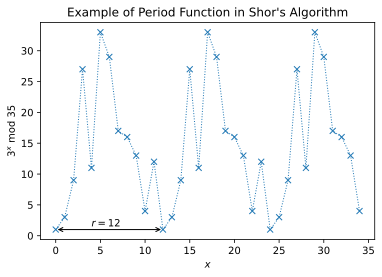

In [3]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

#use matplotlib to plot data in a nice way
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$', title="Example of Period Function in Shor's Algorithm")
try:
    r=yvals[1:].index(1)+1 #we find the index of the next y value equal to 1
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text=f'$r={r}$', xy=(r/3, 1.5))
except:
    print('Could not find the period, check a<N and have no common factors')

### Shor solution

Shor solution was to use QPE algorithm to solve the period finding problem seen above, by estimating the phase of the unitary operator:
$$
U |y\rangle = |a \, y \, \text{ mod N}\rangle 
$$
to see how this relates to period finding, consider applying it to $|1\rangle$ (first state of the computational basis) repeatedly, it will result in multiplying the state of our register by $a$ and then taking the module $N$ each time. After $r$ repetitions we will be back at the state $|1\rangle$, due to the period $r$ of the function $f(x)$ seen before, the register being in the same states as the picture above for $a=3, N=35$.

A superposition of the states in this cycle would be:

$$
|u_0\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} |a^k \text{ mod N}\rangle
$$

which is an **eigenstate** of $U$:

$$
U |u_0\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} |a^{k+1} \text{ mod N}\rangle = |u_0\rangle
$$

where the last equality is because $a^{r} \text{ mod N}=a^0 \text{ mod N}=1$. It has eigenvalue 1. 

So a superposition of the states inside a full period of $U$ is an eigenstate of $U$, though it only has eigenvalue 1. A more interesting eigenstate can be obtained by having a superposition of the states with different phases, for example a state in which the phase of the $k$-th basis state is proportional to $k$:

$$
\begin{aligned}
|u_1\rangle &= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i k}{r}} |a^{k} \text{ mod N}\rangle\\
U|u_1\rangle &= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i k}{r}} |a^{k+1} \text{ mod N}\rangle = e^{\frac{2 \pi i}{r}} |u_1\rangle
\end{aligned}
$$

where the last equality again holds because $e^{\frac{2 \pi i}{r}} e^{-\frac{2 \pi i r}{r}} |a^r \text{ mod N}\rangle = e^{\frac{2 \pi i}{r}} |a^{0} \text{ mod N}\rangle$. Again, we can further generalize this adding a multiplicative constant $s$ to the phase:

$$
\begin{aligned}
|u_s\rangle &= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i s k}{r}} |a^{k} \text{ mod N}\rangle\\
U|u_s\rangle &= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i s k}{r}} |a^{k+1} \text{ mod N}\rangle = e^{\frac{2 \pi i s}{r}} |u_1\rangle
\end{aligned}
$$

and it shows up in the eigenvalue, which now depends on $s$ and $r$. We now have a unique eigenstate for each integer value of $0 \le s \le r-1$. If we use the QPE algorithm, we could estimate the ratio $s/r$ and hence $r$ up to high accuracy. But to prepare $|u_s\rangle$ we need to actually know $r$ beforehand, which defeats the purpose of the algorithm. There's an interesting observation to circumvent this problem, if we sum all these states

$$
\begin{aligned}
\frac{1}{\sqrt{r}} \sum_{s=0}^{r-1} |u_s\rangle &= \frac{1}{r} \sum_{s=0}^{r-1} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i s k}{r}} |a^{k} \text{ mod N}\rangle\\
&= \frac{1}{r} \sum_{k=0}^{r-1} \underbrace{\sum_{s=0}^{r-1} e^{-\frac{2 \pi i s k}{r}}}_{\alpha_{k,r}} |a^k \text{ mod N}\rangle\\
\end{aligned}
$$

and we can easily show that $\alpha_{k,r} = r \delta_{k,0}$. Notice that the summands are all the $r$-th roots of unity raised to $k$-th power, thus shifting the summing index $s$ by 1 will cause us to obtain

$$
\alpha_{k,r} = e^{-\frac{2 \pi i k}{r}} \alpha_{k, r}
$$

which implies the above. Thus

$$
\frac{1}{\sqrt{r}} \sum_{s=0}^{r-1} |u_s\rangle =|1\rangle
$$

So the computational basis state $|1\rangle$ (trivial to prepare) is a superposition of all eigenstates $|u_s\rangle$ of $U$. Notice at this point that

$$
U |1\rangle = \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1} e^{\frac{2 \pi s}{r}} |u_s\rangle
$$

Now we can apply the QPE algorithm, but we first need an observation to understand the result. Recall that the QPE algorithm required a counting register in the state $|0\rangle$ and a second register in the state $|u\rangle$ such that $U|u\rangle=e^{i \theta_u}|u\rangle$, and allowed use to estimate $\theta$ from this setup. Consider the situation where we cannot prepare a single eigenstate of $U$ but another state $|\psi\rangle$, since $U$ is a unitary we can expand it in $|u\rangle$ basis like $|\psi\rangle = \sum_u c_u |u\rangle$. We can then expect, intuitively, the QPE algorithm to behave as follows

$$
|0\rangle |\psi\rangle = \sum_u c_u |0\rangle |u\rangle \implies \sum_u c_u |\tilde{\theta_u}\rangle |u\rangle
$$

where $\tilde{\theta_u}$ is some good approximation to $\theta_u$. We can read the first register to read out $\tilde{\theta_u}$ with probability $|c_u|^2$. 

Apply this argument to $|1\rangle$ above, we see that for each $s$ we will obtain an estimation of $\theta_s \approx s/r$ with probability $(1-\epsilon)/r$, where $\epsilon$ is the required error. Remember the argument about the approximation of QPE (check Neilsen and Chuang), we know that if we take the qubit in the counting register of the QPE algorithm to be $t = 2L+1+\lceil\log(2+1/(2\epsilon))\rceil$ we will obtain the result with the probability given before and an accuracy of $2L+1$ bits, where $L=\lceil\log(N)\rceil$ is the number of bits to represent $N$ in $a^k \text{ mod N}$. 

Obtained the estimation of $s/r$, for any $s$, we need the continued fraction algorithm in order to extract $r$.

#### Continued fraction

So now that we have $\theta \approx s/r$, we need to get $r$, and we do this by using the continue fraction expansion algorithm.

The continued fraction expansion is a representation of any real number by using fractions of integers in the following way

$$
[a_0, \dots, a_M] = a_0 + \frac{1}{a_1 + \frac{1}{a_2 + \frac{1}{\dots  + \frac{1}{a_M}}}}
$$

We call $[a_0, \dots, a_m]$ with $0 \le m \le M$ the *m-th convergent*. The continued fraction algorithm is a procedure to compute this representation, it works like this: consider $31/13$, we want to compute its CF representation, we first split it into a integer part and a fractional part $31/13=2 + \frac{5}{13}$, then we invert the fractional part so that it has a 1 in the numerator and repeat the step before

$$
31/13 = 2 + \frac{1}{\frac{13}{5}} = 2 + \frac{1}{2 + \frac{3}{5}}
$$

repeat, and we arrive at the last step

$$
31/13 = 2 + \frac{1}{2 + \frac{3}{5}} = 2 + \frac{1}{2 + \frac{1}{1 + \frac{2}{3}}} = 2 + \frac{1}{2 + \frac{1}{1 + \frac{1}{1+\frac{1}{2}}}}
$$

we stop here because $1/2$ already has 1 at the numerator, so we conclude the algorithm. All rational numbers will have finite representations that can be found using rational fraction algorithm, while other reals will have infinite ones.

How is it helpful? 

Consider $[a_0, \dots, a_N]$ we have that for each $n$-th convergent

$$
[a_0, \dots, a_n] = \frac{p_n}{q_n}
$$

where $p_n, q_n$ are two integer values defined in a recursive way as $p_0=a_0, q_0=1$ and 

$$
p_n = a_n p_{n-1} + p_{n-2}\\
q_n = a_n q_{n-1} + q_{n-2}
$$

this means that each convergent can be expressed as a rational number, but most importantly implies the following

**Theorem** consider $p/q$ and $x$ both rational numbers such that

$$
\Big\lvert \frac{p}{q} - x \Big\rvert \le \frac{1}{2 q^2}
$$

then $p/q$ is a convergent of the continued fraction representation for $x$.

This means that if $p/q=[a_0, \dots, a_n]$, then $x=[a_0, \dots, a_n, b_0, \dots, b_m]$, but most importantly we have that $p/q$ can be computed by applying the continued fraction algorithm to $x$. 

Going back to our problem, remember that $\theta$ is an approximation of $s/r$ accurate to $2L+1$ bits, thus

$$
\Big\lvert \frac{s}{r} - \theta \Big\rvert \le 2^{-2L-1} \le \frac{1}{2 r^2}
$$

which means that the we can apply the argument above. Thus we apply the continued fraction algorithm to $\theta$ and extract the numbers $p_n$ and $q_n$ for each convergent, each $q_n$ will be a candidate for $r$ which we can check by computing $x^r \text{ mod N}$! This can be computed with the complexity $O(L^3)$ of the continued fraction algorithm.